# YOLO
Potentiellement spécialisable sur les vaches, mais il faut des données déjà annotées
https://docs.ultralytics.com/fr/quickstart/#use-ultralytics-with-python

In [ ]:
#!pip install -U ultralytics

In [ ]:
from ultralytics import YOLO, settings

# Create a new YOLO model from scratch
model = YOLO("yolo11n.yaml") #Juste l'architecture

# Load a pretrained YOLO model
model = YOLO("yolo11n.pt")

# Train the model using the 'coco8.yaml' dataset for 3 epochs
results = model.train(data="coco8.yaml", epochs=3)

# Evaluate the model's performance on the validation set
results = model.val()

results = model("https://ultralytics.com/images/bus.jpg")

results[0].show()

Pour inférer avec des arguments précis:
Tous les arguments https://docs.ultralytics.com/fr/modes/predict/#inference-arguments

In [ ]:

# Run inference on 'bus.jpg' with arguments
model.predict("https://ultralytics.com/images/bus.jpg", save=True, imgsz=320, conf=0.5)

Quelques arguments bien:

- **save_txt**	bool	False	Enregistre les résultats de détection dans un fichier texte, suivant le format [class] [x_center] [y_center] [width] [height] [confidence]. Utile pour l'intégration avec d'autres outils d'analyse.
- **save_conf**	bool	False	Inclut les scores de confiance dans les fichiers texte enregistrés. Améliore le niveau de détail disponible pour le post-traitement et l'analyse.
- **save_crop**	bool	False	Enregistre les images recadrées des détections. Utile pour l'augmentation de l'ensemble de données, l'analyse ou la création d'ensembles de données ciblés pour des objets spécifiques.

- **conf**	float	0.25	Définit le seuil de confiance minimum pour les détections. Les objets détectés avec une confiance inférieure à ce seuil seront ignorés. L'ajustement de cette valeur peut aider à réduire les faux positifs.
- **iou**	float	0.7	Seuil d'Intersection Over Union (IoU) pour la suppression non maximale (NMS). Des valeurs plus faibles entraînent moins de détections en éliminant les boîtes qui se chevauchent, ce qui est utile pour réduire les doublons.
- **imgsz**	int ou tuple	640	Définit la taille de l'image pour l'inférence. Peut être un entier unique 640 pour le redimensionnement carré ou un tuple (hauteur, largeur). Un dimensionnement approprié peut améliorer la détection précision et la vitesse de traitement.
- **device** str None
- **batch** int 1
- **max_det**	int	300	Nombre maximal de détections autorisées par image. Limite le nombre total d'objets que le modèle peut détecter dans une seule inférence, empêchant les sorties excessives dans les scènes denses.
- **classes**	list[int]	None

- **project**	str	None	Nom du répertoire de projet où les sorties de prédiction sont enregistrées si save est activé.
- **name**	str	None	Nom de l'exécution de la prédiction. Utilisé pour créer un sous-répertoire dans le dossier du projet, où les sorties de prédiction sont stockées si save est activé.

On peut train YOLO d'avantage sur des données spécifiques, mais pour ça il faut un bon dataset

Pour faire proprement:

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.yaml")  # build a new model from YAML
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

# Train the model
results = model.train(data="coco8.yaml", epochs=100, imgsz=640)

Récupération des résultats complets (dont confidence score):

In [ ]:
# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box

Quelques fonctions de l'objet result:

- save_txt()	str	Enregistre les résultats de la détection dans un fichier texte et renvoie le chemin d'accès au fichier enregistré.
- save_crop()	None	Enregistre les images de détection recadrées dans le répertoire spécifié.
- summary()	List[Dict[str, Any]]	Convertit les résultats de l'inférence en un dictionnaire récapitulatif avec normalisation optionnelle.
- to_df()	DataFrame	Convertit les résultats de la détection en un DataFrame Polars.
- to_csv()	str	Convertit les résultats de détection au format CSV.
- to_json()	str	Convertit les résultats de détection au format JSON.

#### Settings
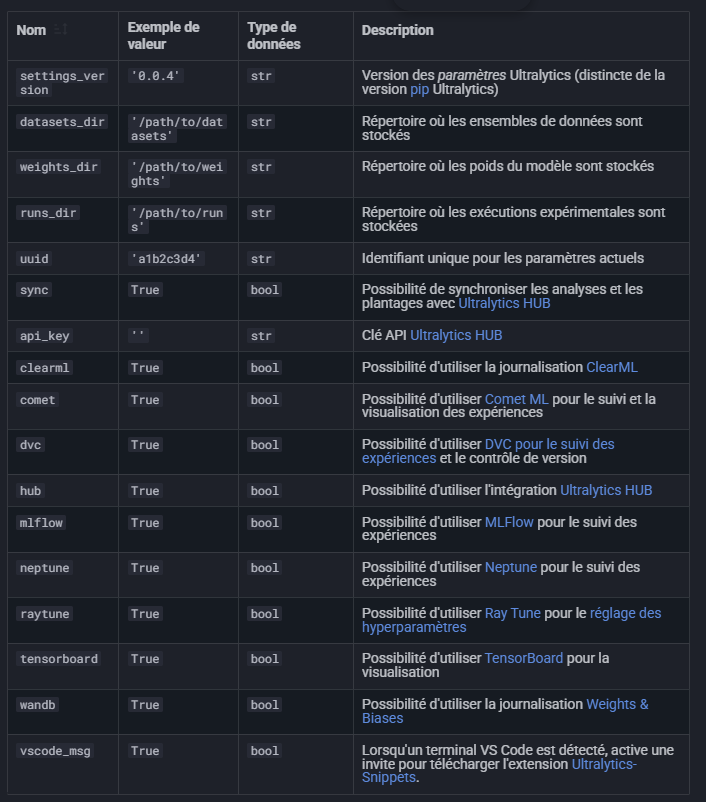

In [ ]:
#Settings
settings.update({"runs_dir": "/path/to/runs", "tensorboard": False})
# Reset settings to default values
settings.reset()

#### Quelques modèles disponibles
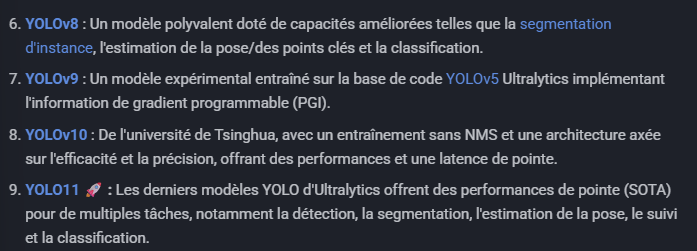



Un YOLO capable de spécifiquement détecter des classes qu'on lui donne:

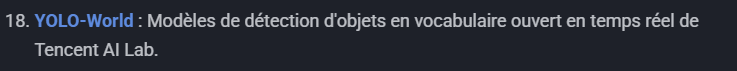


In [ ]:
from ultralytics import YOLO

# Initialize a YOLO-World model
model = YOLO("yolov8s-world.pt")  # or select yolov8m/l-world.pt

# Define custom classes
model.set_classes(["person", "bus"])

# Save the model with the defined offline vocabulary
model.save("custom_yolov8s.pt")

# Export the model
model.export(format="onnx")

# EdgeTAM
https://github.com/facebookresearch/EdgeTAM

Avec deux notebooks bien:
https://github.com/facebookresearch/EdgeTAM/blob/main/notebooks/automatic_mask_generator_example.ipynb
https://github.com/facebookresearch/EdgeTAM/blob/main/notebooks/video_predictor_example.ipynb

Ils ont aussi des fonctions de visualisation bien

#### Install

In [ ]:
!git clone https://github.com/facebookresearch/EdgeTAM.git && cd EdgeTAM

!pip install -e .

#### Imports

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. EdgeTAM is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

#### Initialisation

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

checkpoint = "../checkpoints/edgetam.pt"
model_cfg = "edgetam.yaml"

predictor = build_sam2_video_predictor(model_cfg, checkpoint, device=device)

In [ ]:

# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/bedroom"
inference_state = predictor.init_state(video_path=video_dir)
#predictor.reset_state(inference_state) #si on a fait d'autres tracking avant


#### Mettre la boite d'origine
Possibilité de faire des clicks positifs/négatifs en utilisant 'labels'

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([300, 0, 500, 400], dtype=np.float32)

# Let's add a positive click at (x, y) = (460, 60) to refine the mask
points = np.array([[460, 60]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

#### Propagation

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

#### Ajouter un autre point/une autre box

In [ ]:
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)